In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/en-fr-translation-dataset/en-fr.csv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers

import spacy
from sklearn.model_selection import train_test_split
import unicodedata
import re
from tqdm import tqdm
import random
torch.cuda.empty_cache()

# Loading Dataset

In [3]:
data=pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv',nrows=60000)

In [4]:
data.head()

en  \
0  Changing Lives | Changing Society | How It Wor...   
1                                           Site map   
2                                           Feedback   
3                                            Credits   
4                                           Français   

                                                  fr  
0  Il a transformé notre vie | Il a transformé la...  
1                                       Plan du site  
2                                        Rétroaction  
3                                            Crédits  
4                                            English

In [5]:
data.shape

(60000, 2)

In [4]:
data=data.drop_duplicates()

In [7]:
data.shape

(60000, 2)

In [8]:
data.isna().sum()

en    2
fr    0
dtype: int64

In [9]:
data[data['fr'].duplicated()==True]

en  \
232    « Return to the observatories Next Previous © ...   
528    John Hutchings, an astronomer with the Herzber...   
908                Asteroid 4230 is named in his honour.   
963    Despite its small size, it is ten times more s...   
2404                                           Materials   
...                                                  ...   
59435  The CDIC is the Internet reference for up-to-d...   
59436  The CDIC fosters partnerships and information ...   
59437                          CDIC: www.dairyinfo.gc.ca   
59477  For More Detailed Information Gayle Smith Seni...   
59770  • (Not discussed directly) Other Comments and ...   

                                                      fr  
232    « Retour aux observatoires Suivant Précédent ©...  
528    L'astronome John Hutchings, de l'Institut Herz...  
908    L'astéroïde no 4230 porte son nom en son honneur.  
963    Pourtant, il est dix fois plus sensible que le...  
2404                                                   •  
...                                                  ...  
59435  Dans toutes les branches de notre industrie, n...  
59436  Les produits agroalimentaires canadiens doiven...  
59437  Les consommateurs du monde entier savent qu’il...  
59477  Pour plus de précisions sur les produits et le...  
59770  • (Les discussions n'ont pas porté directement...  

[1727 rows x 2 columns]

In [5]:
data=data.dropna()

In [6]:
data=data[~data.en.duplicated()]

In [12]:
data['fr'].duplicated().sum()

983

In [7]:
data=data[~data.fr.duplicated()]

In [14]:
data.shape

(56597, 2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


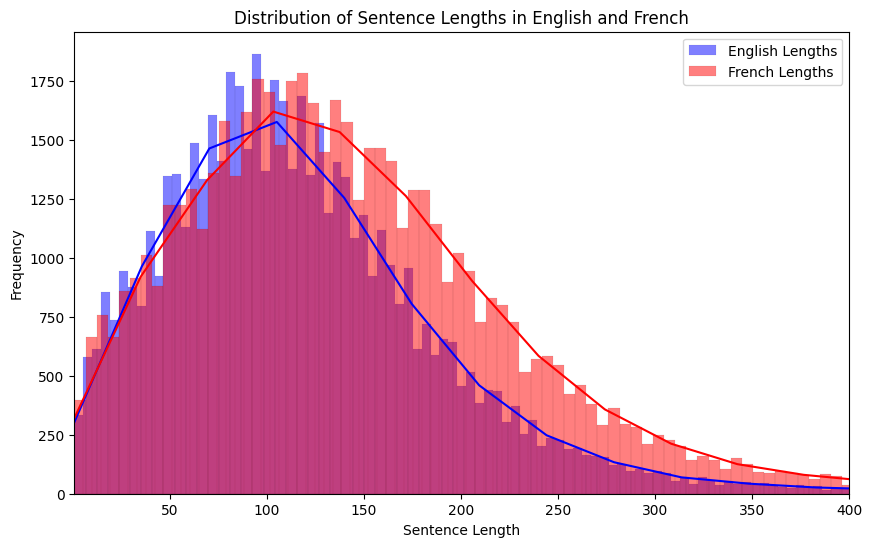

In [10]:
plt.figure(figsize=(10, 6))

# English
sns.histplot(data['en'].apply(lambda x:len(x)), kde=True, color='blue', label='English Lengths')

# French
sns.histplot(data['fr'].apply(lambda x:len(x)), kde=True, color='red', label='French Lengths')
plt.xlim(1, 400)
plt.title('Distribution of Sentence Lengths in English and French')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [12]:
English=data['en']
French=data['fr']

In [13]:
X_train,X_test,Y_train,Y_test=train_test_split(English,French,train_size=0.8,shuffle=True)

In [14]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,train_size=0.8,shuffle=True)

In [18]:
print("X_train:",X_train.shape[0],"row")
print("X_test:",X_test.shape[0],"row")
print("X_val:",X_val.shape[0],"row")

X_train: 36221 row
X_test: 11320 row
X_val: 9056 row


In [18]:
X_train[:3]

47533    Although traditionally associated with providi...
47190    In 2005 Argentina was Canada’s sixth largest t...
49794                              Wyeth SA., Laboratories
Name: en, dtype: object

In [19]:
Y_train[:3]

47533    Même si on les connaît surtout pour leurs frui...
47190    Enfin, le Canada et le Mercosur ont entrepris ...
49794                          0,12 (aliments préemballés)
Name: fr, dtype: object

In [19]:
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c)!='Mn')

In [20]:
def preprocess_sentence(s):
    s=normalize_unicode(s)
    s=re.sub(r"([?.!,])",r" \1 ",s)
    s=re.sub(r'[" "]+',r" ",s)   
    s=s.strip()
    return s

In [21]:
X_train_new=X_train.apply(lambda x:str(x))

In [22]:
Y_train_new=Y_train.apply(lambda x:str(x))

In [23]:
X_val=X_val.apply(lambda x:str(x))
Y_val=Y_val.apply(lambda x:str(x))

In [24]:
X_test=X_test.apply(lambda x:str(x))
Y_test=Y_test.apply(lambda x:str(x))

In [25]:
train_preprocessed_input=[preprocess_sentence(s) for s in X_train]

In [26]:
train_preprocessed_target=[preprocess_sentence(s) for s in Y_train]

In [27]:
def tag_target_sentence(sentences):
    tagged_sentences=map(lambda s: (' ').join(['<sos>',s,'<eos>']),sentences)
    return list(tagged_sentences)

In [28]:
train_tagged_preprocessed_target=tag_target_sentence(train_preprocessed_target)

In [30]:
train_tagged_preprocessed_target[:3]

['<sos> Les principales monnaies de cette categorie sont le franc suisse , le dollar australien et le peso mexicain . <eos>',
 '<sos> Une pierre percee devient un vase consacre a une seule fougere . <eos>',
 '<sos> 11042900 Grains de cereales nda , travailles (ie mondes , perles , tranches ou concasses) A <eos>']

In [29]:
_tokenizer=Tokenizer(oov_token='<unk>',filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
_tokenizer.fit_on_texts(train_preprocessed_input)
_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 36221,
 'word_counts': '{"this": 2655, "increase": 685, "was": 1584, "due": 458, "to": 15411, "a": 9509, "46": 67, "growth": 1017, "of": 22434, "the": 35475, "operational": 17, "profit": 36, "and": 23790, "earnings": 20, "related": 141, "purchase": 108, "auchan": 2, "in": 17013, "mexico": 786, ".": 48185, "indian": 95, "bangladeshi": 5, "curries": 2, ",": 39485, "chinese": 191, "thai": 36, "dishes": 48, "french": 149, "italian": 49, "cuisine": 45, "have": 2057, "long": 207, "history": 42, "uk": 296, "diet": 78, "continue": 241, "be": 2872, "popular": 174, "copenhagen": 15, "is": 7726, "main": 365, "tourist": 35, "hub": 15, "that": 3160, "offers": 80, "various": 223, "train": 4, "bus": 1, "connections": 9, "products": 4049, "with": 4215, "additional": 185, "health": 663, "benefits": 109, "are": 5178, "leading": 232, "list": 243,

In [30]:
source_vocab_size=len(_tokenizer.word_index)+1
print(source_vocab_size)

37257


In [31]:
target_tokenizer=Tokenizer(oov_token='<unk>',filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 36221,
 'word_counts': '{"<sos>": 36221, "cette": 1361, "hausse": 382, "s\'explique": 16, "par": 4912, "une": 4850, "progression": 40, "de": 54798, "46": 66, "la": 23360, "croissance": 994, "du": 12612, "benefice": 14, "d\'exploitation": 19, "et": 24150, "profit": 77, "lie": 8, "a": 20827, "l\'acquisition": 14, "d\'auchan": 1, ",": 46909, "au": 6378, "mexique": 679, ".": 43619, "<eos>": 36221, "les": 23105, "caris": 3, "indiens": 36, "bangladais": 3, "mets": 78, "chinois": 145, "thailandais": 13, "cuisines": 68, "francaise": 16, "italienne": 11, "font": 250, "partie": 479, "depuis": 587, "longtemps": 56, "regime": 100, "alimentaire": 404, "des": 20824, "britanniques": 53, "demeurent": 69, "tres": 620, "apprecies": 10, "copenhague": 10, "est": 5288, "notamment": 267, "un": 4883, "carrefour": 37, "touristique": 40, "offrant": 76,

In [32]:
target_vocab_size=len(target_tokenizer.word_index)+1
print(target_vocab_size)

44654


In [33]:
train_encoder_inputs=_tokenizer.texts_to_sequences(train_preprocessed_input)

In [33]:
train_encoder_inputs[:3]

[[254,
  1841,
  1863,
  14,
  989,
  141,
  533,
  3,
  4,
  13414,
  13,
  51,
  165,
  4935,
  6,
  5586,
  8387,
  3,
  5246,
  3,
  1335,
  83,
  5,
  18469,
  2],
 [7,
  54,
  548,
  42,
  215,
  4936,
  126,
  689,
  1039,
  7,
  195,
  408,
  3,
  9435,
  266,
  2850,
  216,
  461,
  2],
 [18470, 3103, 2, 3, 2923]]

In [34]:
def generate_decoder_inputs_targets(sentences,tokenizer):
    seqs=tokenizer.texts_to_sequences(sentences)
    decoder_inputs=[s[:-1] for s in seqs]
    decoder_targets=[s[1:] for s in seqs] 
    return decoder_inputs,decoder_targets

In [35]:
train_decoder_inputs,train_decoder_targets=generate_decoder_inputs_targets(train_tagged_preprocessed_target,target_tokenizer)

In [65]:
print(train_decoder_inputs[0],train_decoder_targets[0])
print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]),
     target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[5, 662, 13, 15, 1172, 11, 1422, 10, 12555, 8, 26284, 48, 4] [662, 13, 15, 1172, 11, 1422, 10, 12555, 8, 26284, 48, 4, 6]
["<sos> banque du canada caracteristiques a l'intention des aveugles et malvoyants\u2028 2 ."] ["banque du canada caracteristiques a l'intention des aveugles et malvoyants\u2028 2 . <eos>"]


In [36]:
max_encoding_length=len(max(train_encoder_inputs,key=len))
print(max_encoding_length)

1138


In [37]:
max_decoding_length=len(max(train_decoder_inputs,key=len))
print(max_decoding_length)

1113


In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
padded_train_encoder_inputs=pad_sequences(train_encoder_inputs,60,padding='post',truncating='post')
padded_train_decoder_inputs=pad_sequences(train_decoder_inputs,70,padding='post',truncating='post')
padded_train_decoder_targets=pad_sequences(train_decoder_targets,70,padding='post',truncating='post')

In [65]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[  254  1841  1863    14   989   141   533     3     4 13414    13    51
   165  4935     6  5586  8387     3  5246     3  1335    83     5 18469
     2     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[    5   101   145    70     9  1430   462    16    83    78     7   195
   129     3     9 16528    28   125    10  2257     2   169   561     2
  4163     3     2    15  5192     3     2  2357     7     2 22771   233
  2160     4     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 

In [63]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

['<sos> meme si on les connait surtout pour leurs fruits et legumes frais , les tianguis sont aussi des lieux de vente importants de vetements , de produits cosmetiques , de grignotines et de bibelots peu couteux . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>']

In [54]:
data

en  \
0      Changing Lives | Changing Society | How It Wor...   
1                                               Site map   
2                                               Feedback   
3                                                Credits   
4                                               Français   
...                                                  ...   
59995  2.4.5 Cruise Lines There are a number of major...   
59996  For further information on opportunities in th...   
59997  When a menu change does occur, the relevant fo...   
59998  Royal Caribbean's buyer confirmed that they us...   
59999  Carnival Cruise Lines have a subsidiary known ...   

                                                      fr  
0      Il a transformé notre vie | Il a transformé la...  
1                                           Plan du site  
2                                            Rétroaction  
3                                                Crédits  
4                                                English  
...                                                  ...  
59995  2.4.5 Croisiéristes Bon nombre de croisiériste...  
59996  Pour de plus amples renseignements sur les déb...  
59997  Lorsqu'un changement de menu se présente, le r...  
59998  L'acheteur de Royal Caribbean's a indiqué fair...  
59999  Le croisiériste Carnival Cruise Lines confie l...  

[56597 rows x 2 columns]

In [38]:
def process_dataset(inputs,output):
  inputs=inputs.apply(lambda x:str(x))
  outputs=output.apply(lambda x:str(x))

  # Unicode normalization and inserting spaces around punctuation.
  preprocessed_input = [preprocess_sentence(s) for s in inputs]
  preprocessed_output = [preprocess_sentence(s) for s in outputs]

  # Tag target sentences with <sos> and <eos> tokens.
  tagged_preprocessed_output = tag_target_sentence(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = _tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output, 
                                                                    target_tokenizer)
  
  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, 60, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, 70, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, 70, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [39]:
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(X_val,Y_val)

In [40]:
embedding_dim=200
hidden_dim=256
default_dropout=0.2
batch_size=32
epochs=5

In [41]:
encoder_inputs=layers.Input(shape=[None],name='encoder_inputs')
encoder_embeddings=layers.Embedding(source_vocab_size,embedding_dim,mask_zero=True,name='encoder_embedding')
encoder_embedding_output=encoder_embeddings(encoder_inputs)
encoder_lstm=layers.LSTM(hidden_dim,return_state=True,dropout=default_dropout,name='encoder_lstm')
encoder_outputs,state_h,state_c=encoder_lstm(encoder_embedding_output)
encoder_states=(state_h,state_c)

In [42]:
decoder_inputs=layers.Input(shape=[None],name='decoder_inputs')
decoder_embeddings=layers.Embedding(target_vocab_size,embedding_dim,mask_zero=True,name='decoder_embedding')
decoder_embedding_output=decoder_embeddings(decoder_inputs)
decoder_lstm=layers.LSTM(hidden_dim,return_sequences=True,return_state=True,dropout=default_dropout,name='decoder_lstm')
decoder_outputs,_,_=decoder_lstm(decoder_embedding_output,initial_state=encoder_states)
decoder_dense=layers.Dense(target_vocab_size,activation='softmax',name='decoder_dense')
y_proba=decoder_dense(decoder_outputs)

In [43]:
model=tf.keras.Model([encoder_inputs,decoder_inputs],y_proba,name='En-Fr-Seq2Se1_no_Attention')
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [71]:
model.summary()

Model: "En-Fr-Seq2Se1_no_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 200) │  7,530,400 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 200) │  9,010,400 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    467,968 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ not_equal_2[0][0] │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    467,968 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │ 11,578,364 │ decoder_lstm[0][… │
│ (Dense)             │ 45052)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,055,100 (110.84 MB)

 Trainable params: 29,055,100 (110.84 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
es_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [46]:
with tf.device("/device:GPU:0"):
    model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
                     batch_size=32,
                     epochs=epochs,
                     validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
                     callbacks=[es_callback])

Epoch 1/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 417s 368ms/step - accuracy: 0.1199 - loss: 3.7274 - val_accuracy: 0.1090 - val_loss: 4.5302
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 415s 367ms/step - accuracy: 0.1274 - loss: 3.4880 - val_accuracy: 0.1113 - val_loss: 4.5078
Epoch 3/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 414s 366ms/step - accuracy: 0.1342 - loss: 3.2892 - val_accuracy: 0.1132 - val_loss: 4.4965
Epoch 4/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 415s 366ms/step - accuracy: 0.1420 - loss: 3.1067 - val_accuracy: 0.1149 - val_loss: 4.5026
Epoch 5/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 420s 371ms/step - accuracy: 0.1514 - loss: 2.9355 - val_accuracy: 0.1158 - val_loss: 4.5221


In [ ]:
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(X_test,Y_test)

In [50]:
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

354/354 ━━━━━━━━━━━━━━━━━━━━ 51s 142ms/step - accuracy: 0.1163 - loss: 4.5713


[4.556013107299805, 0.1161394938826561]

In [48]:
X_test

45412                    Banco Central do Brasil and IBGE.
40633                      • Government Offices of Iceland
6197     The full gamut of frozen fish products (includ...
11870    According to industry sources, there is a 15%-...
4553     Past reforms were required due to strong level...
                               ...                        
58939    In Canada, commercially available aquaculture ...
32749    This agreement will strengthen relationships b...
57475                        Indian O. Ter Georgia Grenada
37849                             Francis Keymolen France:
49927                               • customs declaration;
Name: en, Length: 11320, dtype: object

In [51]:
padded_test_encoder_inputs

array([[ 6114,   623,   331, ...,     0,     0,     0],
       [   20,   104,  1535, ...,     0,     0,     0],
       [    4,   789, 14341, ...,     0,     0,     0],
       ...,
       [ 1102,   253,     2, ...,     0,     0,     0],
       [ 4588, 11067,   368, ...,     0,     0,     0],
       [   20,   284,  2314, ...,     0,     0,     0]], dtype=int32)

In [54]:
type(X_test.iloc[0])

str

In [55]:
text=input("Enter English text to translate to French")

Enter English text to translate to French my name is seif


In [56]:
text

'my name is seif'

In [59]:
text=str(text)

In [60]:
preprocessed_input = [preprocess_sentence(s) for s in text]

In [61]:
preprocessed_input

['m', 'y', '', 'n', 'a', 'm', 'e', '', 'i', 's', '', 's', 'e', 'i', 'f']

In [62]:
encoder_inputs = _tokenizer.texts_to_sequences(preprocessed_input)

In [63]:
encoder_inputs

[[526],
 [1033],
 [],
 [907],
 [9],
 [526],
 [138],
 [],
 [347],
 [137],
 [],
 [137],
 [138],
 [347],
 [1105]]

In [64]:
padded_encoder_inputs = pad_sequences(encoder_inputs, 60, padding='post', truncating='post')

In [ ]:
# text=text.apply(lambda x:str(x))
# outputs=output.apply(lambda x:str(x))

# Unicode normalization and inserting spaces around punctuation.
preprocessed_input = [preprocess_sentence(s) for s in inputs]
# preprocessed_output = [preprocess_sentence(s) for s in outputs]

# Tag target sentences with <sos> and <eos> tokens.
# tagged_preprocessed_output = tag_target_sentence(preprocessed_output)

# Vectorize encoder source sentences.
encoder_inputs = _tokenizer.texts_to_sequences(preprocessed_input)

# Vectorize and create decoder input and target sentences.
# decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output, 
#                                                                 target_tokenizer)

# Pad all collections.
padded_encoder_inputs = pad_sequences(encoder_inputs, 60, padding='post', truncating='post')
# padded_decoder_inputs = pad_sequences(decoder_inputs, 70, padding='post', truncating='post')
# padded_decoder_targets = pad_sequences(decoder_targets, 70, padding='post', truncating='post')

In [66]:
padded_encoder_inputs

array([[ 526,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [1033,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [70]:
def translate_sentence(sentence, max_length=50):
    # Tokenize the input sentence
    input_seq = _tokenizer.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=50, padding='post')
    
    # Initialize target sequence with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_tokenizer.word_index.get('<sos>', 1)
    
    output_sentence = []
    
    for _ in range(max_length):
        output_tokens = model.predict([input_seq, target_seq])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, '<unk>')
        
        if sampled_word == '<eos>':
            break
        
        output_sentence.append(sampled_word)
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
    
    return ' '.join(output_sentence)

In [74]:

translation = translate_sentence("this is a sentence")
print("English: this is a sentence")
print(f"French (predicted): {translation}")
print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━